# Monte carlo Agent
The agent uses Monte Carlo estimation to learn an action-value function Q(s,a) and selects
actions via an epsilon-greedy policy. Q-value updates can be performed using either first-visit
or every-visit Monte Carlo methods.

## Aider functions to discretize the continuous space

In [1]:
import gymnasium as gym
import text_flappy_bird_gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

## Monte Carlo Agent implementation

In [39]:
class MonteCarloAgent:
    def __init__(self, env, height, width, pipe_gap, n_actions, epsilon=0.1, epsilon_annealing=0.99, gamma=0.99, mc_method='first_visit'):
        self.env = env
        self.height = height
        self.width = width
        self.pipe_gap = pipe_gap
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.gamma = gamma
        self.mc_method = mc_method
        self.epsilon_annealing = epsilon_annealing
        
        self.Q = defaultdict(lambda: np.zeros(n_actions))
        self.returns = defaultdict(list)
        
    def select_action(self, state, eval_mode=False):
        """
        Select an action for a given state.
        If eval_mode is True, use greedy policy without exploration.
        """
        if eval_mode or np.random.rand() > self.epsilon:
            return np.argmax(self.Q[state])
        else:
            return self.env.action_space.sample()
    
    def generate_episode(self):
        episode = []
        state, _ = self.env.reset()
        done = False
        
        while not done:
            action = self.select_action(state)
            next_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            episode.append((state, action, reward))
            state = next_state
        return episode
    
    def update_Q(self, episode):
        visited = set()
        G = 0
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.gamma * G + reward
            
            if self.mc_method == 'first_visit':
                if (state, action) not in visited:
                    self.returns[(state, action)].append(G)
                    self.Q[state][action] = np.mean(self.returns[(state, action)])
                    visited.add((state, action))
            elif self.mc_method == 'every_visit':
                self.returns[(state, action)].append(G)
                self.Q[state][action] = np.mean(self.returns[(state, action)])
            else:
                raise ValueError("mc_method must be 'first_visit' or 'every_visit'")
                
    def train(self, num_episodes=1000, log_interval=100):
        episode_rewards = []
        
        for i_episode in range(1, num_episodes + 1):
            episode = self.generate_episode()
            total_reward = sum([x[2] for x in episode])
            episode_rewards.append(total_reward)
            self.update_Q(episode)
            self.epsilon = max(self.epsilon * self.epsilon_annealing, 0.01)

            if i_episode % log_interval == 0:
                avg_reward = np.mean(episode_rewards[-log_interval:])
                print(f"Episode {i_episode}/{num_episodes} - Average Reward: {avg_reward:.2f}")
                    
        return episode_rewards

    def play_game(self, render=False):
        """
        Play one full game using a greedy policy (eval mode).
        Returns the total reward earned.
        """
        state, _ = self.env.reset()
        done = False
        total_reward = 0
        
        while not done:
            if render:
                self.env.render()
            action = self.select_action(state, eval_mode=True)
            next_state, reward, terminated, truncated, info = self.env.step(action)
            total_reward += reward
            state = next_state
            done = terminated or truncated
        
        return total_reward


In [30]:

# Main function to run the Monte Carlo agent.
def run_monte_carlo_agent(num_episodes = 1000, height = 15, width = 20, pipe_gap = 4):
    """
    Runs the Monte Carlo agent on the Text Flappy Bird environment and logs performance.
    
    This function:
    - Initializes the environment (using the distance-based "TextFlappyBird-v0" version).
    - Instantiates the Monte Carlo agent with specified parameters.
    - Trains the agent and logs rewards per episode.
    - Plots the rewards to show convergence progress.
    
    Returns:
        agent (MonteCarloAgent): The trained agent.
        rewards (list): List of total rewards per episode.
    """
    # Initialize the environment.
    env = gym.make('TextFlappyBird-v0', height = height, width = width, pipe_gap = pipe_gap)
    n_actions = env.action_space.n
    
    # Create the Monte Carlo agent with desired parameters.
    agent = MonteCarloAgent(env, height, width, pipe_gap, n_actions,
                            epsilon=0.1,
                            gamma=0.99,
                            mc_method='first_visit')  # Change to 'every_visit' if desired.
    
    # Adjust as needed for convergence.
    rewards = agent.train(num_episodes=num_episodes, log_interval=100)
    
    # Plot the running average of total rewards per episode to visualize performance.
    window_size = 100  # You can adjust the window size as needed.
    running_avg = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
    plt.figure(figsize=(10, 5))
    plt.plot(running_avg)
    plt.xlabel('Episode')
    plt.ylabel(f'Running Average Total Reward (window={window_size})')
    plt.title('Monte Carlo Agent Performance on Text Flappy Bird (Running Average)')
    plt.show()

    return agent, rewards


Episode 100/7000 - Average Reward: 7.54
Episode 200/7000 - Average Reward: 9.48
Episode 300/7000 - Average Reward: 9.72
Episode 400/7000 - Average Reward: 10.18
Episode 500/7000 - Average Reward: 9.78
Episode 600/7000 - Average Reward: 10.20
Episode 700/7000 - Average Reward: 10.50
Episode 800/7000 - Average Reward: 10.95
Episode 900/7000 - Average Reward: 11.24
Episode 1000/7000 - Average Reward: 17.65
Episode 1100/7000 - Average Reward: 15.29
Episode 1200/7000 - Average Reward: 17.93
Episode 1300/7000 - Average Reward: 18.13
Episode 1400/7000 - Average Reward: 18.61
Episode 1500/7000 - Average Reward: 17.42
Episode 1600/7000 - Average Reward: 18.36
Episode 1700/7000 - Average Reward: 19.85
Episode 1800/7000 - Average Reward: 19.75
Episode 1900/7000 - Average Reward: 21.25
Episode 2000/7000 - Average Reward: 24.33
Episode 2100/7000 - Average Reward: 29.53
Episode 2200/7000 - Average Reward: 30.21
Episode 2300/7000 - Average Reward: 29.40
Episode 2400/7000 - Average Reward: 29.24
Episo

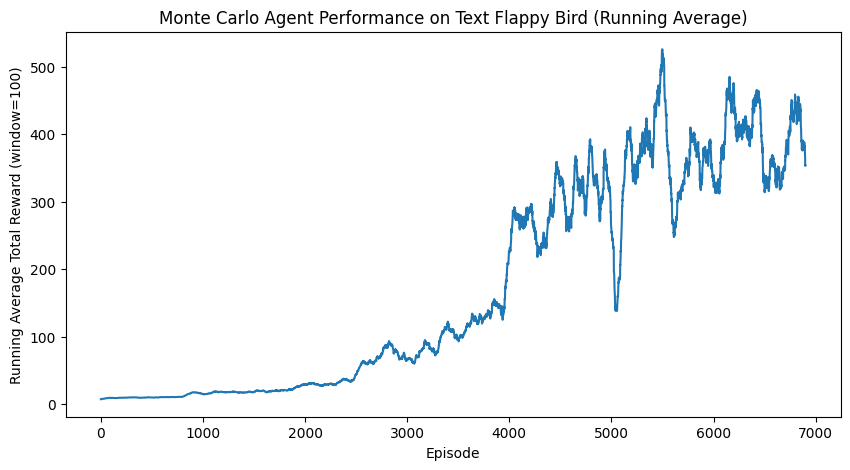

In [41]:
mc_agent, mc_rewards = run_monte_carlo_agent(7000)

In [47]:
class SarsaLambdaAgent:
    def __init__(self, env, height, width, pipe_gap, n_actions, alpha=0.1, gamma=0.99, lambd=0.9, 
                 epsilon=0.1, epsilon_annealing=0.99):
        self.env = env
        self.height = height
        self.width = width
        self.pipe_gap = pipe_gap
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.lambd = lambd
        self.epsilon = epsilon
        self.epsilon_annealing = epsilon_annealing

        self.Q = defaultdict(lambda: np.zeros(n_actions))
        self.E = defaultdict(lambda: np.zeros(n_actions))

    def select_action(self, state, eval_mode=False):
        if eval_mode or np.random.rand() > self.epsilon:
            return np.argmax(self.Q[state])
        else:
            return self.env.action_space.sample()

    def train(self, num_episodes=1000, log_interval=100):
        episode_rewards = []

        for i_episode in range(1, num_episodes + 1):
            total_reward = 0
            state, _ = self.env.reset()
            action = self.select_action(state)
            self.E = defaultdict(lambda: np.zeros(self.n_actions))
            done = False

            while not done:
                next_state, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated
                total_reward += reward
                next_action = self.select_action(next_state)

                td_target = reward + self.gamma * self.Q[next_state][next_action] if not done else reward
                delta = td_target - self.Q[state][action]

                self.E[state][action] += 1

                for s in list(self.E.keys()):
                    self.Q[s] += self.alpha * delta * self.E[s]
                    self.E[s] *= self.gamma * self.lambd

                state = next_state
                action = next_action

            episode_rewards.append(total_reward)
            self.epsilon = max(self.epsilon * self.epsilon_annealing, 0.01)

            if i_episode % log_interval == 0:
                avg_reward = np.mean(episode_rewards[-log_interval:])
                print(f"Episode {i_episode}/{num_episodes} - Average Reward: {avg_reward:.2f}")

        return episode_rewards

    def play_game(self, render=False):
        """
        Play one full game using greedy policy (eval mode).
        Returns the total reward earned.
        """
        state, _ = self.env.reset()
        done = False
        total_reward = 0

        while not done:
            if render:
                self.env.render()
            action = self.select_action(state, eval_mode=True)
            next_state, reward, terminated, truncated, info = self.env.step(action)
            total_reward += reward
            state = next_state
            done = terminated or truncated

        return total_reward


In [48]:
# Main function to run the Sarsa(λ) agent.
def run_sarsa_lambda_agent(num_episodes=1000, height = 15, width = 20, pipe_gap = 4):
    """
    Runs the Sarsa(λ) agent on the Text Flappy Bird environment and logs performance.
    
    This function:
      - Initializes the environment (using the distance-based "TextFlappyBird-v0" version).
      - Instantiates the Sarsa(λ) agent with specified parameters.
      - Trains the agent and logs rewards per episode.
      - Plots the running average of rewards to show convergence progress.
    
    Returns:
        agent (SarsaLambdaAgent): The trained agent.
        rewards (list): List of total rewards per episode.
    """
    # Initialize the environment with the specified parameters.
    env = gym.make('TextFlappyBird-v0', height=height, width=width, pipe_gap=pipe_gap)
    n_actions = env.action_space.n
    
    # Create the Sarsa(λ) agent with desired parameters.
    agent = SarsaLambdaAgent(env, width, height, pipe_gap, n_actions, 
                             alpha=0.1,
                             gamma=0.99,
                             lambd=0.9,
                             epsilon=0.1,
                             epsilon_annealing=0.99)
    
    # Train the agent.
    rewards = agent.train(num_episodes=num_episodes, log_interval=100)
    
    # Plot the running average of total rewards per episode.
    window_size = 100  # Adjust the window size as desired.
    running_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    plt.figure(figsize=(10, 5))
    plt.plot(running_avg)
    plt.xlabel('Episode')
    plt.ylabel(f'Running Average Total Reward (window={window_size})')
    plt.title('Sarsa(λ) Agent Performance on Text Flappy Bird (Running Average)')
    plt.show()
    
    return agent, rewards

Episode 100/40000 - Average Reward: 5.27
Episode 200/40000 - Average Reward: 5.94
Episode 300/40000 - Average Reward: 6.30
Episode 400/40000 - Average Reward: 7.02
Episode 500/40000 - Average Reward: 6.45
Episode 600/40000 - Average Reward: 6.87
Episode 700/40000 - Average Reward: 6.34
Episode 800/40000 - Average Reward: 6.19
Episode 900/40000 - Average Reward: 6.47
Episode 1000/40000 - Average Reward: 6.42
Episode 1100/40000 - Average Reward: 6.76
Episode 1200/40000 - Average Reward: 6.61
Episode 1300/40000 - Average Reward: 6.55
Episode 1400/40000 - Average Reward: 6.34
Episode 1500/40000 - Average Reward: 6.41
Episode 1600/40000 - Average Reward: 6.79
Episode 1700/40000 - Average Reward: 6.31
Episode 1800/40000 - Average Reward: 6.32
Episode 1900/40000 - Average Reward: 6.90
Episode 2000/40000 - Average Reward: 6.44
Episode 2100/40000 - Average Reward: 6.31
Episode 2200/40000 - Average Reward: 5.84
Episode 2300/40000 - Average Reward: 6.23
Episode 2400/40000 - Average Reward: 6.49
E

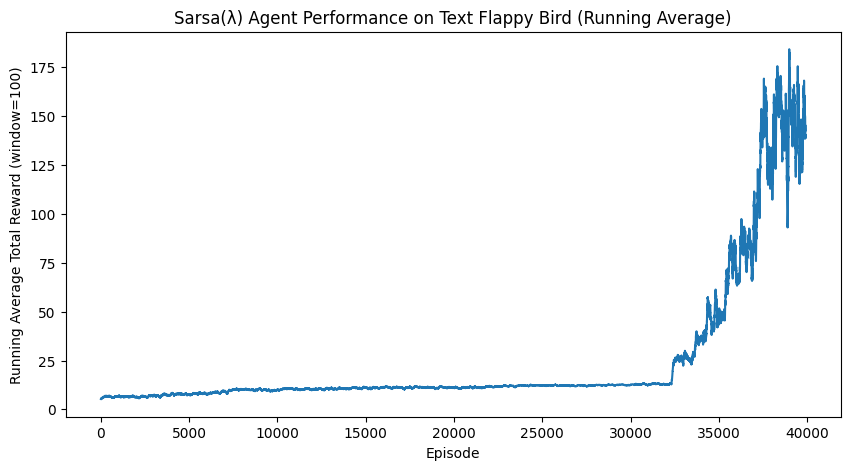

In [74]:
sarsa_agent, sarsa_rewards = run_sarsa_lambda_agent(40000)

In [75]:
def plot_state_value_function(agent):
    """
    Plots the state value function V(s) computed from the agent's Q-values.
    
    The state value function is defined as:
        V(s) = max_a Q(s, a)
    
    This function assumes that the agent's state space is 2-dimensional.
    The discrete state indices are based on the bins created using the agent's `bins` attribute.
    
    Parameters:
        agent: An agent instance (e.g., MonteCarloAgent or SarsaLambdaAgent)
               that contains a dictionary `Q` mapping state tuples to arrays of action-values.
    """
    
    n_states_dim0 = agent.height + 1
    n_states_dim1 = agent.width + 1
    
    # Initialize a grid for the state value function.
    V = np.zeros((n_states_dim0, n_states_dim1))
    
    # Populate the grid:
    # For each discrete state, compute V(s) = max_a Q(s,a).
    # If a state hasn't been visited, its value remains 0.
    for i in range(n_states_dim0):
        for j in range(n_states_dim1):
            state = (i, j)
            if state in agent.Q:
                V[i, j] = np.max(agent.Q[state])
            else:
                V[i, j] = 0  # Alternatively, you could assign np.nan to indicate unvisited states.
    
    # Plot the state value function using imshow.
    plt.figure(figsize=(8, 6))
    # 'origin' set to 'lower' so that the (0,0) index is at the bottom-left of the plot.
    plt.imshow(V, origin='lower', interpolation='nearest', aspect='auto',
               extent=[0, n_states_dim1, 0, n_states_dim0])
    plt.colorbar(label='V(s) = max_a Q(s,a)')
    plt.xlabel('Discretized State Dimension 1')
    plt.ylabel('Discretized State Dimension 0')
    plt.title('State Value Function')
    plt.show()


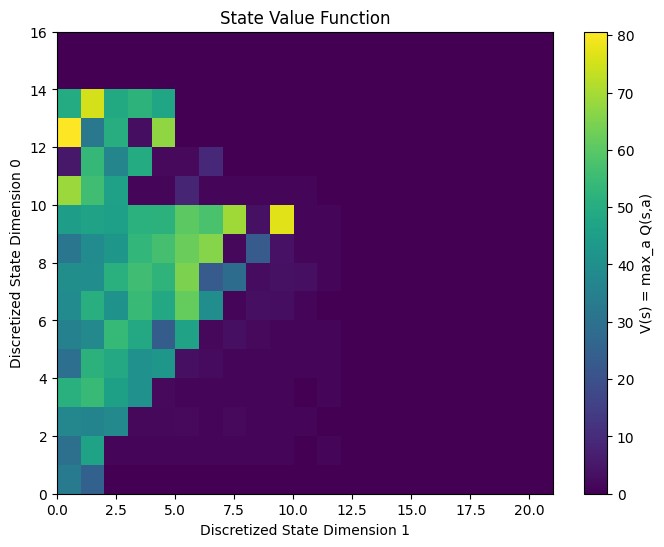

In [76]:
plot_state_value_function(mc_agent)

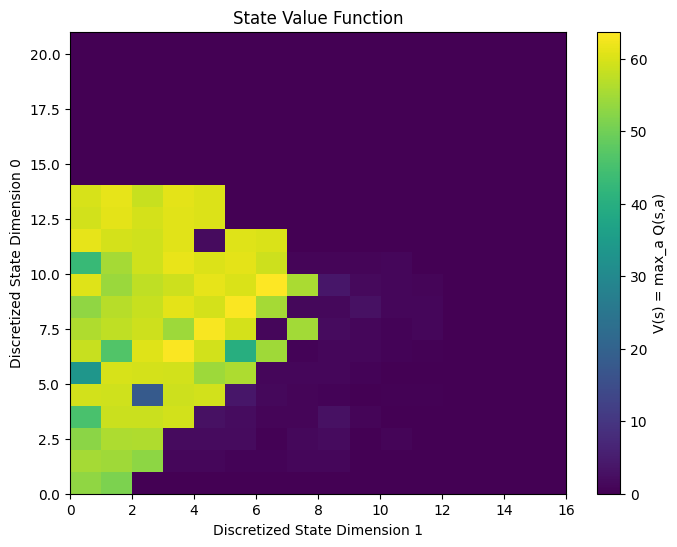

In [77]:
plot_state_value_function(sarsa_agent)

In [78]:
from itertools import product
from collections import defaultdict
import numpy as np
import tqdm

def run_parameter_sweep(agent_class, param_grid, env_fn, num_episodes=1000, n_runs=3, n_eval=20, 
                        reward_threshold=None, agent_extra_kwargs=None):
    """
    Run a parameter sweep and return metrics grouped by category.
    """
    if agent_extra_kwargs is None:
        agent_extra_kwargs = {}
        
    keys = list(param_grid.keys())
    all_combos = list(product(*[param_grid[k] for k in keys]))
    results = []

    for combo in tqdm.tqdm(all_combos, desc="Grid Search"):
        param_dict = dict(zip(keys, combo))
        run_metrics = defaultdict(list)

        for _ in range(n_runs):
            env = env_fn()
            n_actions = env.action_space.n
            agent = agent_class(env=env, n_actions=n_actions, **agent_extra_kwargs, **param_dict)
            rewards = agent.train(num_episodes=num_episodes)

            # Vitesse d'apprentissage
            if reward_threshold is not None:
                window_size = 100
                found = False
                for i in range(len(rewards) - window_size):
                    if np.mean(rewards[i:i+window_size]) >= reward_threshold:
                        run_metrics["time_to_learn"].append(i + window_size)
                        found = True
                        break
                if not found:
                    run_metrics["time_to_learn"].append(num_episodes)

            # Efficacité cumulative
            run_metrics["auc"].append(np.sum(rewards))

            # Performance finale
            test_scores = [agent.play_game() for _ in range(n_eval)]
            run_metrics["final_score_mean"].append(np.mean(test_scores))
            run_metrics["final_score_std"].append(np.std(test_scores))

        result = {**param_dict}
        # Moyennes des n_runs
        for metric in run_metrics:
            result[metric] = np.mean(run_metrics[metric])
        results.append(result)

    return results

def summarize_best_configs(results, metrics=["final_score_mean", "final_score_std", "time_to_learn", "auc"]):
    """
    Print the best parameter configuration for each metric.
    """
    df = pd.DataFrame(results)

    print("\n=== 🔍 Best Configurations by Metric ===\n")
    for metric in metrics:
        ascending = metric in ["final_score_std", "time_to_learn"]  # for these, lower is better
        best_row = df.sort_values(by=metric, ascending=ascending).iloc[0]
        print(f"🏆 Best {metric}: {best_row[metric]:.3f}")
        print("Config:", {k: best_row[k] for k in df.columns if k not in metrics})
        print("-" * 50)




In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(results, x_param, y_param, metric, annot=True, fmt=".1f", figsize=(8, 6), cmap="viridis"):
    """
    Plot a heatmap of a metric from the parameter sweep results.
    
    Parameters:
        results (list): Output from run_parameter_sweep.
        x_param (str): Name of parameter for X-axis.
        y_param (str): Name of parameter for Y-axis.
        metric (str): Metric to display (e.g., 'final_score_mean', 'auc', etc.).
    """
    df = pd.DataFrame(results)
    heatmap_data = df.pivot(index=y_param, columns=x_param, values=metric)
    
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap_data, annot=annot, fmt=fmt, cmap=cmap)
    plt.title(f"{metric} heatmap")
    plt.xlabel(x_param)
    plt.ylabel(y_param)
    plt.tight_layout()
    plt.show()


In [84]:
# Nombre total d'episodes pour chaque agent
total_number = 10000

In [85]:
# Paramètres de sweep pour le MonteCarloAgent
param_grid = {
    'gamma': [0.95, 0.99, 1.0],
    'epsilon': [0.1, 0.05],
    'mc_method': ['first_visit', 'every_visit'] 
}

# Paramètres supplémentaires pour l'agent qui ne sont pas extraits de l'environnement
agent_extra_kwargs = {
    'height': 15,
    'width': 20,
    'pipe_gap': 4
}

def make_env():
    return gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

results = run_parameter_sweep(MonteCarloAgent, param_grid, env_fn=make_env, num_episodes=total_number, 
                               n_runs=3, n_eval=10, reward_threshold=50, agent_extra_kwargs=agent_extra_kwargs)

plot_heatmap(results, x_param='gamma', y_param='epsilon', metric='final_score_mean')


Grid Search:   0%|          | 0/12 [00:00<?, ?it/s]

Episode 100/10000 - Average Reward: 5.05
Episode 200/10000 - Average Reward: 6.40
Episode 300/10000 - Average Reward: 6.84
Episode 400/10000 - Average Reward: 7.54
Episode 500/10000 - Average Reward: 8.42
Episode 600/10000 - Average Reward: 9.58
Episode 700/10000 - Average Reward: 10.57
Episode 800/10000 - Average Reward: 10.65
Episode 900/10000 - Average Reward: 10.91
Episode 1000/10000 - Average Reward: 11.92
Episode 1100/10000 - Average Reward: 12.45
Episode 1200/10000 - Average Reward: 13.68
Episode 1300/10000 - Average Reward: 20.18
Episode 1400/10000 - Average Reward: 22.05
Episode 1500/10000 - Average Reward: 22.52
Episode 1600/10000 - Average Reward: 22.10
Episode 1700/10000 - Average Reward: 22.23
Episode 1800/10000 - Average Reward: 25.63
Episode 1900/10000 - Average Reward: 23.28
Episode 2000/10000 - Average Reward: 24.27
Episode 2100/10000 - Average Reward: 26.17
Episode 2200/10000 - Average Reward: 28.69
Episode 2300/10000 - Average Reward: 24.91
Episode 2400/10000 - Avera

Grid Search:   0%|          | 0/12 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [86]:
total_number = 40000

In [ ]:
# Exemple de sweep :
param_grid = {
    'alpha': [0.05, 0.1, 0.2],
    'gamma': [0.95, 0.99],
    'lambd': [0.0, 0.5, 0.9]
}


# Lancer le sweep
results = run_parameter_sweep(SarsaLambdaAgent, param_grid, env_fn=make_env, num_episodes=total_number, n_runs=3, n_eval=10, reward_threshold=50)

# Visualiser une métrique
plot_heatmap(results, x_param='alpha', y_param='lambd', metric='final_score_mean')
